# III - Auto-encoder

## Importar librerias

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.metrics import MSE
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.losses import categorical_crossentropy

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

## Parametros de entrenamiento

In [4]:
lr = 1.0
epochs = 50
batch_size = 256
np.random.seed(14)

## Cargar y visualizar el dataset

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
n_classes = np.max(np.unique(y_train)) + 1

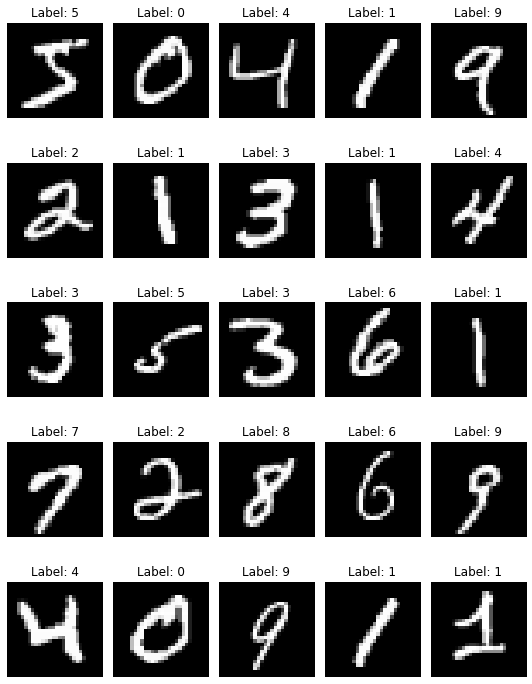

In [6]:
num = 25
images = x_train[:num]
labels = y_train[:num]
num_row = 5
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
    ax.axis('off')
plt.tight_layout()
plt.show()

## Preparacion de los datos

In [7]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [8]:
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes) #one-hot encoding

In [9]:
x_train.shape = (x_train.shape[0], np.prod(x_train.shape[1:]))
x_test.shape = (x_test.shape[0], np.prod(x_test.shape[1:]))

In [10]:
x_train.shape

(60000, 784)

## Generamos datos ruidosos y visualizamos

In [9]:
def noisy_data(x):
    x_noisy = x + 0.6 * np.random.normal(loc=0.0, scale=1.0, size=x.shape)
    x_noisy = np.clip(x_noisy, 0.0, 1.0)
    return x_noisy

In [10]:
x_train_noisy = noisy_data(x_train)
x_test_noisy = noisy_data(x_test)

## Crear el modelo

In [11]:
# Model
#---------------------------------------------------------------------#
input_layer = Input(shape=x_train.shape[1:])
encoded = Dense(500, activation='relu')(input_layer)
encoded = Dense(200, activation='relu')(encoded)
encoded = Dense(100, activation='relu')(encoded)
#---------------------------------------------------------------------#
decoded = Dense(200, activation='relu')(encoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(x_train.shape[1], activation='sigmoid')(decoded)
#---------------------------------------------------------------------#
model = Model(input_layer, decoded)

In [17]:
Adadelta_optimizer = Adadelta(learning_rate=lr, rho=0.95)
model.compile(optimizer=Adadelta_optimizer, loss='binary_crossentropy', metrics=['mse'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 500)               392500    
                                                                 
 dense_1 (Dense)             (None, 200)               100200    
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 200)               20200     
                                                                 
 dense_4 (Dense)             (None, 500)               100500    
                                                                 
 dense_5 (Dense)             (None, 784)               392784

## Entrenar el modelo

In [13]:
start_time = time.time()
history = model.fit(x_train_noisy, x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test_noisy, x_test), shuffle=True, verbose=1)
end_time = time.time()
print('\nElapsed Dense Model training time: {:.5f} seconds'.format(end_time-start_time))

Epoch 1/50
235/235 [==============================] - 6s 23ms/step - loss: 0.2969 - mse: 0.0794 - val_loss: 0.2624 - val_mse: 0.0675
Epoch 2/50
235/235 [==============================] - 6s 24ms/step - loss: 0.2572 - mse: 0.0654 - val_loss: 0.2525 - val_mse: 0.0639
Epoch 3/50
235/235 [==============================] - 6s 24ms/step - loss: 0.2446 - mse: 0.0609 - val_loss: 0.2317 - val_mse: 0.0565
Epoch 4/50
235/235 [==============================] - 5s 23ms/step - loss: 0.2279 - mse: 0.0551 - val_loss: 0.2195 - val_mse: 0.0524
Epoch 5/50
235/235 [==============================] - 5s 23ms/step - loss: 0.2106 - mse: 0.0492 - val_loss: 0.2027 - val_mse: 0.0466
Epoch 6/50
235/235 [==============================] - 5s 23ms/step - loss: 0.1983 - mse: 0.0450 - val_loss: 0.1933 - val_mse: 0.0433
Epoch 7/50
235/235 [==============================] - 6s 23ms/step - loss: 0.1896 - mse: 0.0420 - val_loss: 0.1837 - val_mse: 0.0400
Epoch 8/50
235/235 [==============================] - 6s 25ms/step - 

## Evaluar el proceso de entrenamiento

In [14]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

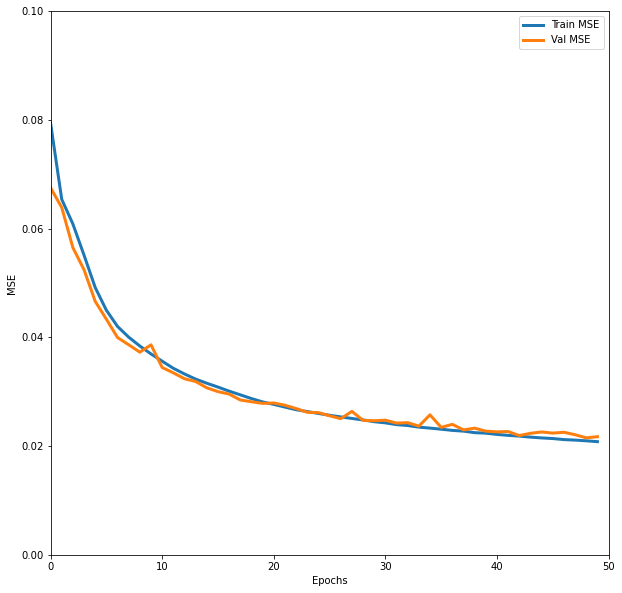

In [15]:
# Plot
f = plt.figure(figsize=(10,10))
plt.plot(history.history['mse'], linewidth=3, label='Train MSE')
plt.plot(history.history['val_mse'], linewidth=3, label='Val MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.axis([0, 50, 0, 0.1])
plt.legend(loc='upper right')
plt.show()

## Visualizamos algunas predicciones

1/1 [==============================] - 0s 92ms/step


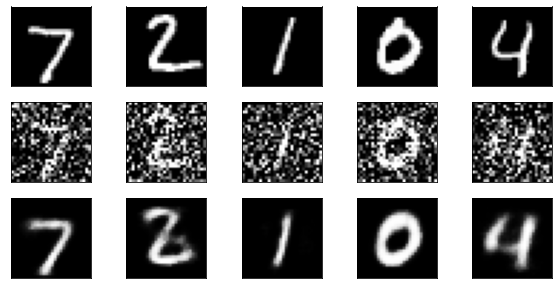

In [16]:
# Denoise test
n = 5
y_test_noisy = model.predict(x_test_noisy[:n], verbose=1)
f = plt.figure(figsize=(10, 5))
for i in range(n):
    # Original test image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Noisy image
    ax = plt.subplot(3, n, i + 1+ n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Decoded image
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(y_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()